In [1]:
expt_name="seismicTL_circular1"
fname="/home/pawan/Dropbox/SymAE/"+expt_name
fnametest="/home/pawan/Dropbox/SymAE/test2"+expt_name

In [2]:
%run ../core.py

In [3]:
dat=h5py.File(fname+".h5", 'r')
dattest=h5py.File(fnametest+".h5", 'r')
Xo_train=np.array(dat["data"])
Xo_test=np.array(dattest["data"])


# Xo_test=np.repeat(Xo_test,4,axis=0)
# Xo_train=np.expand_dims(Xo_train,[3])
# Xo_test=np.expand_dims(Xo_test,[4])
    
nsamp, ntau, n1, n2, nfilt=Xo_train.shape
with open(str(fname+'.json')) as f:
    labels_train = json.load(f)
labels_train=[labels_train[i] for i in range(0,nsamp)]
#with open(str(fnametest+'.json')) as f:
#    labels_test = json.load(f)
#labels_test=[labels_test[str(i)] for i in range(1,3)]


print("shape of Xo_train",np.shape(Xo_train))
print("shape of Xo_test",np.shape(Xo_test))
print("number of samples Xo_train\t", nsamp)
print("number of instances in each datapoint Xo_train\t", ntau)
print("number of samples in each channel\t", (n1,n2))

shape of Xo_train (6000, 20, 100, 160, 1)
shape of Xo_test (2, 20, 100, 160, 1)
number of samples Xo_train	 6000
number of instances in each datapoint Xo_train	 20
number of samples in each channel	 (100, 160)


In [4]:

# Xo_train, labels_train, Xo_test, labels_test=read_datapoints(fname, fnametest)
# nsamp, ntau,n1,n2,nfilt=Xo_train.shape


# In[5]:


# from sklearn.model_selection import train_test_split
# from sklearn.utils import shuffle
# Xo_train, Xo_test=train_test_split(Xo, test_size=0.1, shuffle=True)
# Xo_train, labels_train=shuffle(Xo_train, labels_train, n_samples=9000)
# Xo_train, Xo_test, labels_train, labels_test=train_test_split(Xo_train, labels_train, test_size=0.1, shuffle=True)
# nsamp, ntau, n1,n2,nfilt =Xo_train.shape

# from tensorflow.keras.mixed_precision import experimental as mixed_precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)


In [5]:
# %load ../symae_core.py

#%% Load packages
import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers
tfkltd= tf.keras.layers.TimeDistributed

import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

print(tf.__version__)


class NuisanceEncoder(tf.keras.Model):
  def __init__(self, kernel_sizes, filters, rdown=[2,2,1,1], tdown=[1,1,2,2], fstep=[2,4,8], latent_dim=512):
    super(NuisanceEncoder, self).__init__(name='')
    k1,k2=kernel_sizes

    # self.c1=tfkltd(tfkl.Conv2D(filters,(k1,k2),activation='elu'))
    self.c1=tfkltd(tfkl.Conv2D(filters,(k1,k2),strides=(rdown[0],tdown[0]),activation='elu'))
    # self.mp1=tfkltd(tfkl.MaxPool2D(pool_size=(rdown[0],tdown[0])))
    # self.c3=tfkltd(tfkl.Conv2D(filters//fstep[0],(k1,k2),activation='elu'))
    self.c4=tfkltd(tfkl.Conv2D(filters//fstep[0],(k1,k2),strides=(rdown[1],tdown[1]),activation='elu'))
    # self.mp2=tfkltd(tfkl.MaxPool2D(pool_size=(rdown[1],tdown[1])))
    self.c5=tfkltd(tfkl.Conv2D(filters//fstep[1],(k1,k2),strides=(rdown[2],tdown[2]),activation='elu'))
    # self.c6=tfkltd(tfkl.Conv2D(filters//fstep[1],(k1,k2),activation='elu'))
    # self.mp3=tfkltd(tfkl.MaxPool2D(pool_size=(rdown[2],tdown[2])))
    # self.c7=tfkltd(tfkl.Conv2D(filters//fstep[2],(k1,k2),activation='elu'))
    self.c8=tfkltd(tfkl.Conv2D(filters//fstep[2],(k1,k2),strides=(rdown[3],tdown[3]),activation='elu'))
    self.bn=tfkltd(tfkl.BatchNormalization())
    # self.mp4=tfkltd(tfkl.MaxPool2D(pool_size=(rdown[3],tdown[3])))
    self.f=tfkltd(tfkl.Flatten())
    self.d=tfkltd(tfkl.Dense(latent_dim))

  def call(self, input_tensor, training=False):
    # n, ntau, nr, nt, nc = input_tensor.get_shape()
    x=self.c1(input_tensor)
    # x=self.c2(x)
    # x=self.mp1(x)
    # x=self.c3(x)
    x=self.c4(x)
    # x=self.mp2(x)
    x=self.c5(x)
    # x=self.c6(x)
    # x=self.mp3(x)
    # x=self.c7(x)
    x=self.c8(x)
    x=self.bn(x, training=training)
    # x=self.mp4(x)
    x=self.f(x)
    out=self.d(x)
    return out
  def model(self, x):
    return tfk.Model(inputs=x, outputs=self.call(x))


class SymmetricEncoder(tf.keras.Model):
  def __init__(self, kernel_sizes, filters, rdown=[2,2,2,1], tdown=[2,4,4,4],latent_dim=8, fstep=[2,4,8]):
    super(SymmetricEncoder, self).__init__(name='')
    k1,k2=kernel_sizes

    self.c11=tfkltd(tfkl.Conv2D(filters,(k1,k2),activation='elu'))
    self.c12=tfkltd(tfkl.Conv2D(filters//fstep[0],(k1,k2),strides=(rdown[0],tdown[0]),activation='elu'))
    # self.mp11=tfkltd(tfkl.MaxPool2D(pool_size=(rdown[0],tdown[0])))
    self.c13=tfkltd(tfkl.Conv2D(filters//fstep[1],(k1,k2),activation='elu'))
    self.c14=tfkltd(tfkl.Conv2D(filters//fstep[2],(k1,k2),strides=(rdown[1],tdown[1]),activation='elu'))
    # self.mp12=tfkltd(tfkl.MaxPool2D(pool_size=(rdown[1],tdown[1])))


    self.c21=tfkl.Conv2D(filters,(k1,k2),strides=(rdown[2],tdown[2]),activation='elu')
    # self.c22=tfkl.Conv2D(filters//fstep[0],(k1,k2),padding='same',activation='elu')
    # self.mp21=tfkl.MaxPool2D(pool_size=(rdown[2],tdown[2]))
    # self.c23=tfkl.Conv2D(filters//fstep[1],(k1,k2),padding='same',activation='elu')
    self.c24=tfkl.Conv2D(filters//fstep[2],(k1,k2),strides=(rdown[3],tdown[3]),activation='elu')
    self.bn=tfkl.BatchNormalization()
    # self.mp22=tfkl.MaxPool2D(pool_size=(rdown[3],tdown[3]))
    self.f=tfkl.Flatten()
    self.d=tfkl.Dense(latent_dim)

  def call(self, input_tensor, training=False):
    # n, ntau, nr, nt, nc = input_tensor.get_shape()
    x=self.c11(input_tensor)
    x=self.c12(x)
    # x=self.mp11(x)
    x=self.c13(x)
    x=self.c14(x)
    # x=self.mp12(x)
    x=tf.math.reduce_mean(x,axis=1)
    x=self.c21(x)
    # x=self.c22(x)
    # x=self.mp21(x)
    # x=self.c23(x)
    x=self.c24(x)
    x=self.bn(x, training=training)
    # x=self.mp22(x)
    x=self.f(x)
    out=self.d(x)
    return out
  def model(self, x):
    return tfk.Model(inputs=x, outputs=self.call(x))


class DistributeZsym(tf.keras.Model):
  def __init__(self, ntau, nz0, nzi):
    super(DistributeZsym, self).__init__(name='')

    self.nz0=nz0
    self.nzi=nzi
    self.ntau=ntau
    self.ri=tfkl.Reshape(target_shape=(ntau,nzi))
    self.repeat=tfkl.RepeatVector(ntau)
#     Xhatr=tfkl.Reshape(target_shape=(ntau,latent_dimr))(Xhatr)

  def call(self, z, training=False):

    z0,zi=tf.split(z,[self.nz0, self.ntau*self.nzi],axis=1)
    zi=self.ri(zi)
    z0=self.repeat(z0)
    out=tfkl.concatenate([z0, zi],axis=2)
    return out
  def model(self, x):
    return tfk.Model(inputs=x, outputs=self.call(x))


class LatentCat(tf.keras.Model):
  def __init__(self, alpha=1.0):
    super(LatentCat, self).__init__(name='')

    self.drop=tfkl.GaussianDropout(alpha)
    # self.drop=tfkl.Dropout(alpha)

  def call(self, zsym, znuisance,training=False):
    znuisance=self.drop(znuisance,training=training)
    z=tfkl.concatenate([zsym, znuisance])
    return z


class Mixer(tf.keras.Model):
  def __init__(self, kernel_sizes, filters, upfacts, nt, nr, fstep=[8,4,2]):
    super(Mixer, self).__init__(name='')
    k1,k2=kernel_sizes
    rup,tup=upfacts

    filt_in=64

    self.d1=tfkltd(tfkl.Dense(units=((nr//rup)*(nt//tup)*filt_in),activation='elu'))
    self.r2=tfkltd(tfkl.Reshape(target_shape=((nr//rup),(nt//tup),filt_in)))
    self.c1=tfkltd(tfkl.Conv2D(filters//fstep[0],(k1,k2),padding='same',activation='elu'))
    self.us1=tfkltd(tfkl.UpSampling2D(size=(rup,tup)))
    # self.c2=tfkltd(tfkl.Conv2D(filters//fstep[1],(k1,k2),padding='same',activation='elu'))
    self.c3=tfkltd(tfkl.Conv2D(filters//fstep[1],(k1,k2),padding='same',activation='elu'))
    self.bn=tfkltd(tfkl.BatchNormalization())
    self.c4=tfkltd(tfkl.Conv2D(filters//fstep[2],(k1,k2),padding='same',activation='elu'))
    # self.c5=tfkltd(tfkl.Conv2D(filters//fstep[2],(k1,k2),padding='same',activation='elu'))
    self.c6=tfkltd(tfkl.Conv2D(1,(k1,k2),padding='same'))

  def call(self, z, training=False):
    x=self.d1(z)
    x=self.r2(x)
    x=self.us1(x)
    x=self.c1(x)
    # x=self.c2(x)
    x=self.c3(x)
    x=self.bn(x, training=training)
    x=self.c4(x)
    # x=self.c5(x)
    out=self.c6(x)
    return out
  def model(self, x):
    return tfk.Model(inputs=x, outputs=self.call(x))


Num GPUs Available:  2
2.4.1


In [6]:

strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
# strategy = tf.distribute.MirroredStrategy()
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1","/gpu:2","/gpu:3","/gpu:4","/gpu:5","/gpu:6","gpu:7"])
# strategy = tf.distribute.OneDeviceStrategy("/gpu:0")
# strategy = tf.distribute.get_strategy()
# strategy = tf.distribute.MirroredStrategy(devices=["gpu:7"])
# strategy = tf.distribute.experimental.CentralStorageStrategy() 
#%% model
with strategy.scope():
    
    
    encoder_input=tfk.Input(shape=(ntau,n1,n2,1), dtype='float32', name='encoder_input')
    
#     downsampler=Downsampler([2,25],8,2)
#     downsampler=DownsamplerDense(200,nt)
#     xd=downsampler(encoder_input)

#     downsampler.summary(line_length=120)
#     tf.keras.utils.plot_model( downsampler, to_file='encoderdown.png', show_shapes=True, 4
    kernel_size=(5,5)
    nfilt=64
    
    nz0=10
    symencoder1=SymmetricEncoder(kernel_size,nfilt,[2,2,2,2],[2,2,2,2],nz0, [1,1,1])
    xz0=symencoder1(encoder_input)
    
    z0=tfkl.Flatten()(xz0)
    
    nz0=z0.get_shape()[1]
    
    report(symencoder1.model(encoder_input),"symencoder")
    symencoder=tf.keras.Model(encoder_input, z0, name="symencoder")
    
    
    nzi=200
    nencoder1=NuisanceEncoder(kernel_size,nfilt,[2,2,2,2],[2,2,2,2],[1,1,1],nzi)
    
    xzi=nencoder1(encoder_input)

    zi=tfkl.Flatten()(xzi)

    report(nencoder1.model(encoder_input),"nencoder")
    nencoder=tf.keras.Model(encoder_input, zi, name="nencoder")
    
    decoder_input = tf.keras.Input(shape=(nzi*ntau+nz0), name='latentcode')
    
    distzsym=DistributeZsym(ntau, nz0, nzi)
    xdhat=distzsym(decoder_input)
    
    report(distzsym.model(decoder_input),"distzsym")

    mixer=Mixer(kernel_size,nfilt,(10,10),n2,n1,[1,1,1])
    xhat=mixer(xdhat)

#     upsampler=Upsampler([2,25],8,2)
#     upsampler=UpsamplerDense(nt,200)
#     xhat=upsampler(xdhat)
    
    znuisance=nencoder(encoder_input)
    zsym=symencoder(encoder_input)
    
    
    report(mixer.model(tfk.Input(shape=(ntau,nzi+nz0))),"mixer")
    
#     report(upsampler,"upsampler")
    
    

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

In [7]:

with strategy.scope():
    latentcat=LatentCat(0.4)
    
    encoder=tf.keras.Model(encoder_input, latentcat(zsym,znuisance), name="encoder")

    decoder=tf.keras.Model(decoder_input, xhat, name="decoder")
    report(decoder, "decoder")
    
    model=tf.keras.Model(encoder_input, decoder(latentcat(zsym,znuisance)) , name='autoencoder')
    report(model, "autoencoder")

model.compile(optimizer='adam', loss='mse')

Model: "decoder"
________________________________________________________________________________________________________________________________________________________________________________________________________
Layer (type)                                                                              Output Shape                                                                    Param #                       
latentcode (InputLayer)                                                                   [(None, 4010)]                                                                  0                             
________________________________________________________________________________________________________________________________________________________________________________________________________
distribute_zsym (DistributeZsym)                                                          (None, 20, 210)                                                                 0        

In [8]:
batch_size=4
ds_train=tf.data.Dataset.from_tensor_slices((Xo_train, Xo_train))
# ds_train = tf.data.TFRecordDataset(filenames=["Xo.tfrecords"])
#   print(ds_train)
ds_train = ds_train.shuffle(nsamp,reshuffle_each_iteration=True) 
ds_train=ds_train.batch(batch_size)
ds_train = ds_train.cache()
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test=tf.data.Dataset.from_tensor_slices((Xo_test, Xo_test))
ds_test=ds_test.batch(batch_size)
# ds_test = ds_test.cache()
# ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)


In [9]:


options = tf.data.Options()
options.experimental_optimization.noop_elimination = True
options.experimental_optimization.map_vectorization.enabled = True
# options.experimental_threading.max_intra_op_parallelism = 1 # reduces CPU usage?
options.experimental_optimization.apply_default_optimizations = True
ds_train = ds_train.with_options(options)
# ds_test = ds_test.with_options(options)

In [18]:
#cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=base_dir + expt_name + '_TFmodel_save', save_weights_only=True, verbose=1)
#model.fit(Xr,Xr,epochs=10, batch_size=batch_size,  callbacks=[cp_callback, generate_and_save_images(), history], validation_split=0.1, shuffle=True)
#model.fit(Xr,Xr,epochs=10, batch_size=batch_size,  callbacks=[generate_and_save_images(), history], validation_split=0.1, shuffle=True)
# model.fit(Xo,Xo,epochs=100, batch_size=batch_size, callbacks=[tbCallBack], shuffle=True, validation_split=0.05)
history=model.fit(ds_train,epochs=100,  shuffle=True, validation_data=ds_test,)
# model.fit(ds_train,epochs=40 )
# model.fit(Xo,Xo,epochs=1,  batch_size=4)#, callbacks=[tbCallBack])

Epoch 1/100
1500/1500 [==============================] - 121s 81ms/step - loss: 0.1742 - val_loss: 0.1021
Epoch 2/100
1500/1500 [==============================] - 154s 103ms/step - loss: 0.1719 - val_loss: 0.0921
Epoch 3/100
1500/1500 [==============================] - 173s 115ms/step - loss: 0.1692 - val_loss: 0.0933
Epoch 4/100
1500/1500 [==============================] - 189s 126ms/step - loss: 0.1671 - val_loss: 0.0939
Epoch 5/100
1500/1500 [==============================] - 205s 136ms/step - loss: 0.1650 - val_loss: 0.0926
Epoch 6/100
1500/1500 [==============================] - 195s 130ms/step - loss: 0.1634 - val_loss: 0.0875
Epoch 7/100
1500/1500 [==============================] - 191s 127ms/step - loss: 0.1614 - val_loss: 0.0878
Epoch 8/100
1500/1500 [==============================] - 211s 141ms/step - loss: 0.1602 - val_loss: 0.0865
Epoch 9/100
1500/1500 [==============================] - 218s 145ms/step - loss: 0.1585 - val_loss: 0.0849
Epoch 10/100
1500/1500 [==============

In [19]:
Xo_train.dtype, Xo_test.dtype

KeyboardInterrupt: 

(dtype('<f4'), dtype('<f4'))

In [11]:
%run ../plots.py

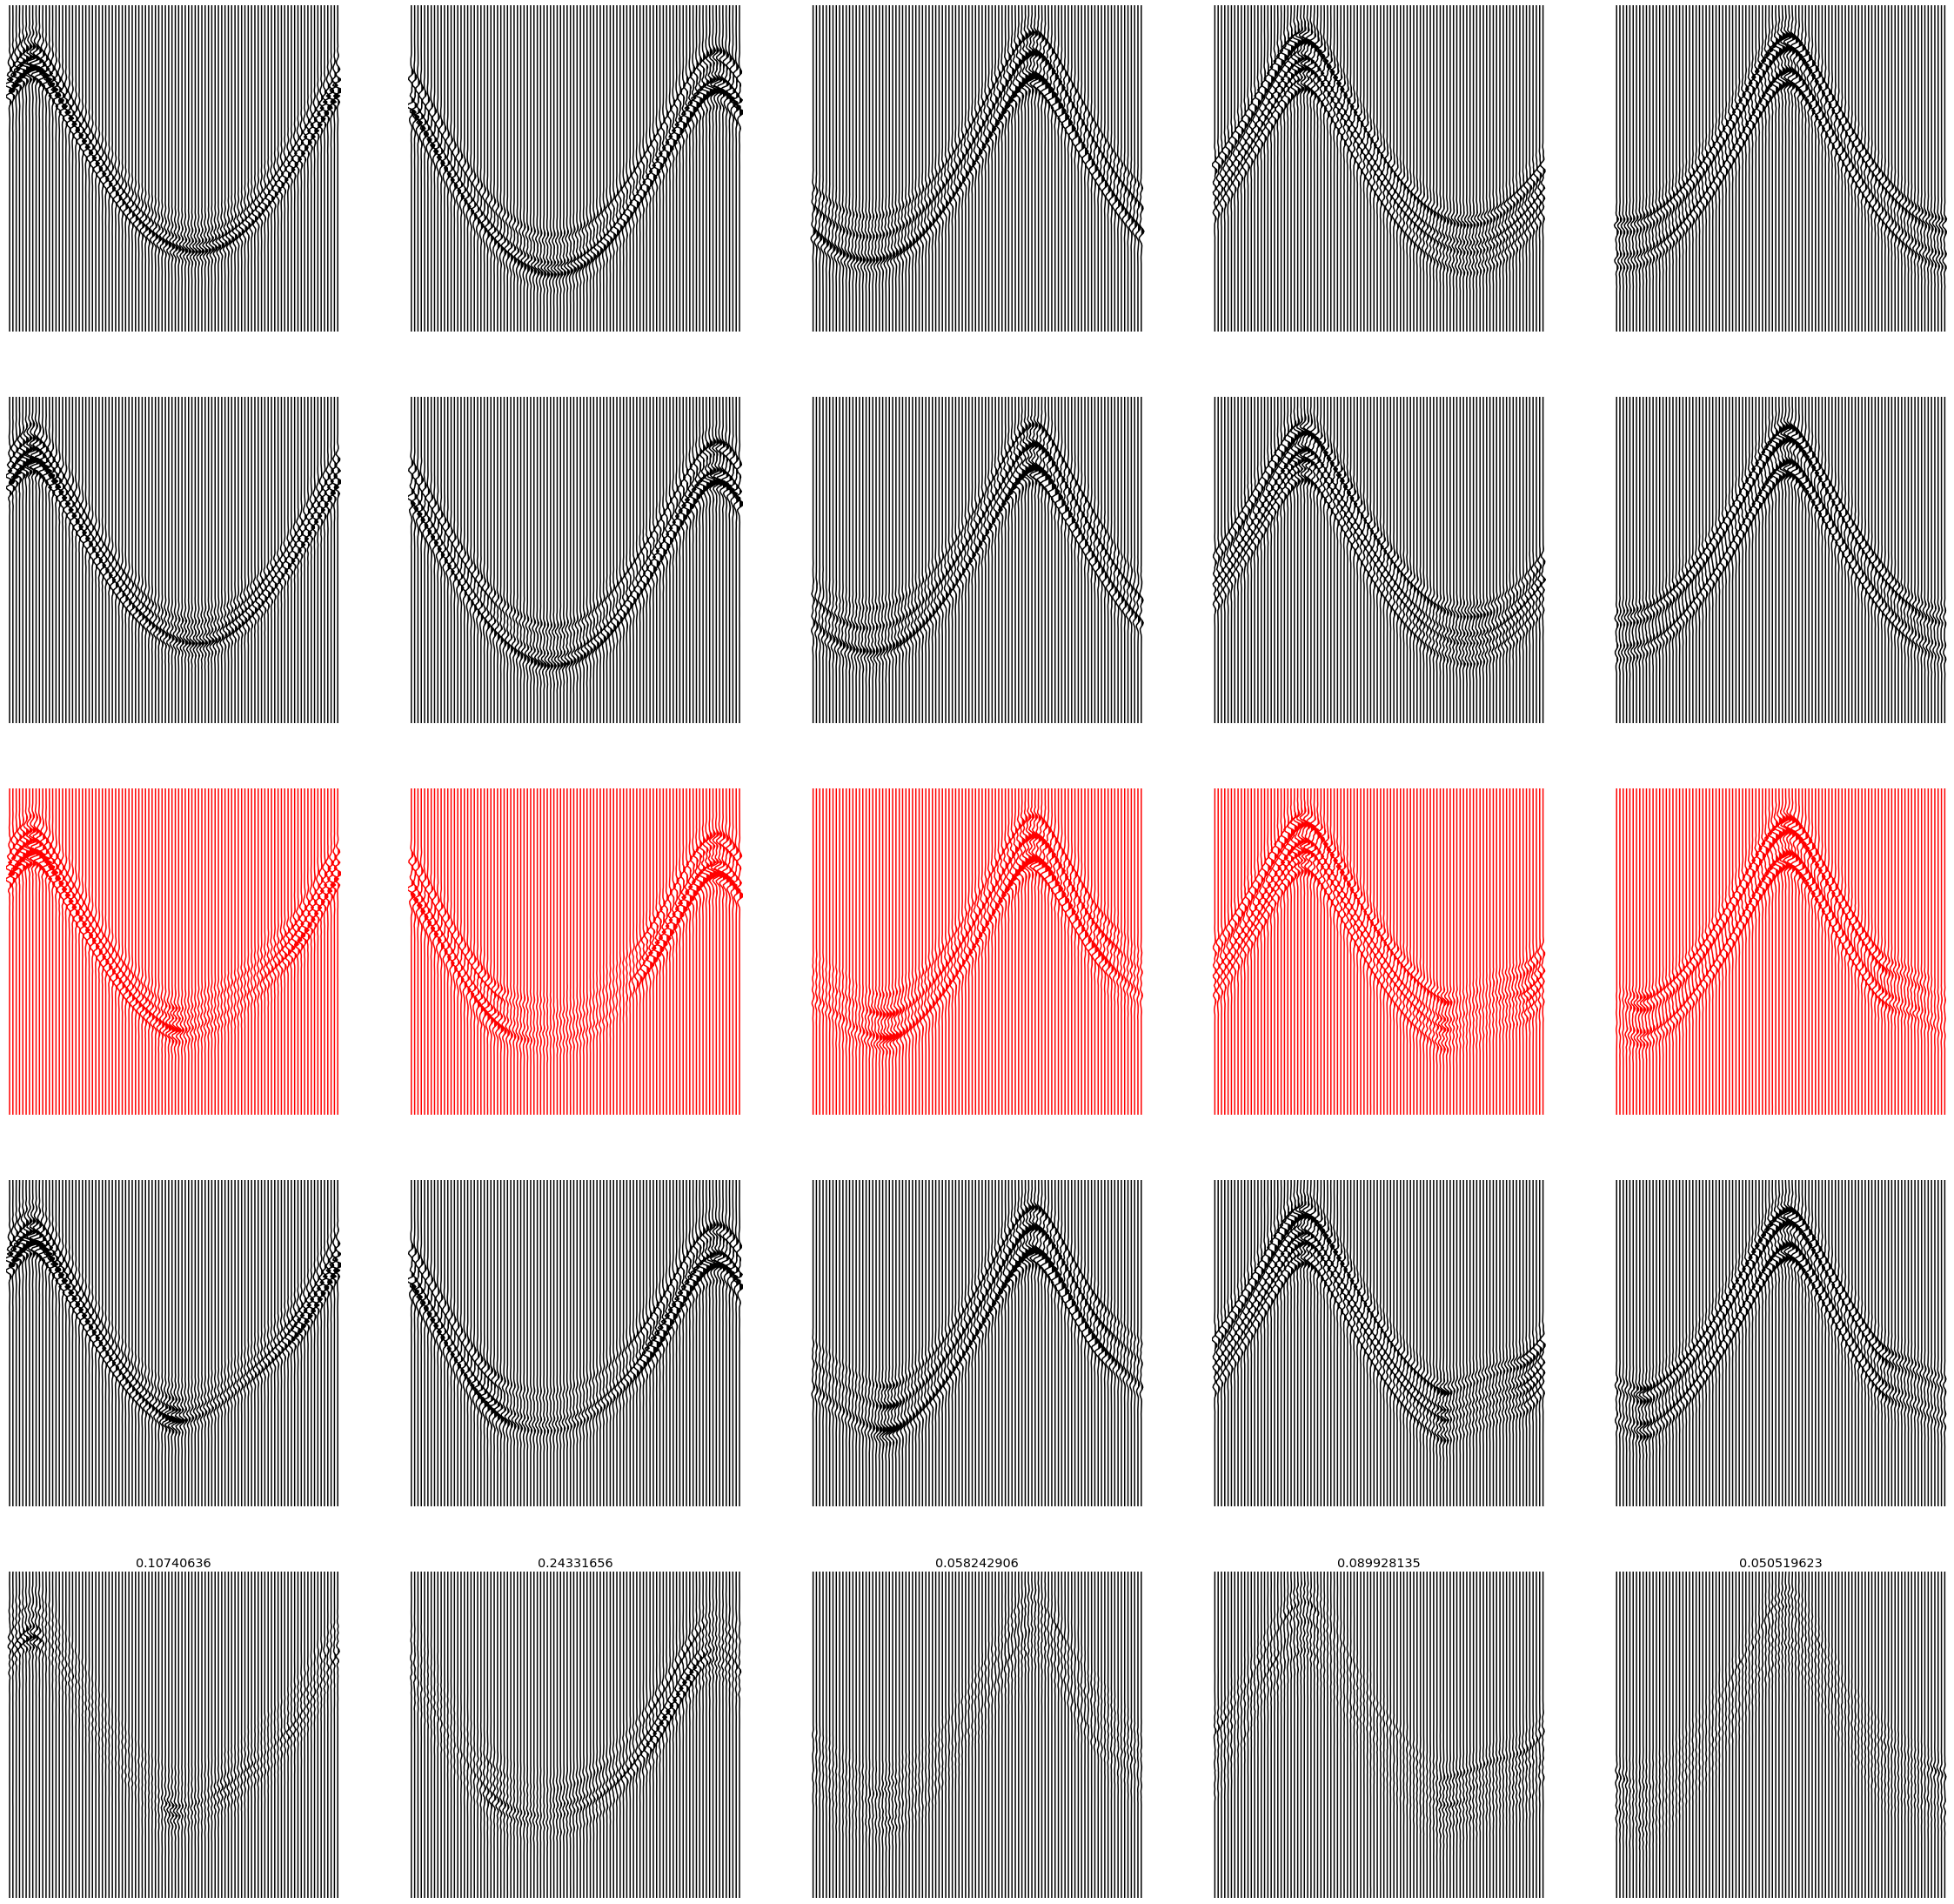

In [21]:
plot_seismic(Xo_test, labels_train,symencoder, nencoder, decoder)


In [59]:
print("Previous Dropout "+str(model.layers[2].layers[-1].rate))
model.save_weights("temp_weights")
new_dropout=0.5
model.layers[2].layers[-1].rate=new_dropout
model = tfk.models.clone_model(model)
model.compile(optimizer='adam', loss='mse')
model.load_weights("temp_weights")
print("New Dropout "+str(model.layers[2].layers[-2].rate))

AttributeError: 'Flatten' object has no attribute 'rate'

In [ ]:

labelindices={'base0': [], 'moni1' : [], 'moni2' : []}
for (i,label) in enumerate(labels):
    labelindices[label[0][0]].append(i)


# In[281]:


labels[labelindices['moni2']][0][0]


# # Visualize Latent Space

# In[ ]:



# In[80]:


# visualizing latent space

"""
fig=plt.figure(dpi=100, figsize=(15,8))
for label in ['100', '200', '300', '400', '500']:
    i = labelindices[label][0:1]
    
    with tf.device('/cpu:0'):
        latentsr=encoderr(Xo[i])
    
    

    """

with tf.device('/gpu'):
    test_large_indices = [np.random.randint(1, nsamp) for i in range(0,64)]
    latentsT=nencoder.predict(Xo_train                           [test_large_indices])
    latentsr=symencoder.predict(Xo_train[test_large_indices])
    #print(np.shape(latentsr))
    fig, axs = plt.subplots(2, 2, dpi=100, figsize=(15,8))
    a=axs[0,0].imshow(latentsr, aspect=1)
    #for l in latentsr:
    #    a=axs[0,0].plot(l)
    axs[0,0].set_title('G')
    plt.colorbar(a, ax=axs[0,0]) 

    #a=axs[1,0].imshow(tf.exp(latentsr[1]), aspect=1)
    #axs[1,0].set_title('sigma encoderr output for samples')
    #plt.colorbar(a, ax=axs[1,0]) 

    b=axs[0,1].imshow(latentsT, aspect=1)
    axs[0,1].set_title('Z')
    plt.colorbar(b, ax=axs[0,1]) 
    
plt.gcf()
#b=axs[1,1].imshow(tf.exp(latentsT[1]), aspect=1)
#axs[1,1].set_title('sigma encoderT output for samples')
#plt.colorbar(b, ax=axs[1,1]) 


# In[67]:


plt.imshow(latentsT)


# In[68]:


with tf.device('/gpu'):
    latentsr={'base0': [], 'moni1':[],'moni2':[]}
    for label in ['base0', 'moni1', 'moni2']:
        i = labelindices[label][1:20]
        with tf.device('/gpu:0'):
            latentsr[label]=symencoder.predict(Xo_train[i])


# In[69]:


fig, ax = plt.subplots(2,5,dpi=500, figsize=(3,2))
markers=['r', 'b', 'c', 'g', 'm']
subs=['(a)', '(b)', '(c)', '(d)', '(e)']
for (i,label) in enumerate(['base0', 'moni1', 'moni2', 'base0', 'base0']):
    lmean=np.mean(latentsr[label], axis=0)
    #ax[i].plot(lmean, color='k', linewidth=0.1)
    ax[1,i].imshow(latentsr[label].T)
    # Hide grid lines
    ax[1,i].grid(False)
#     Hide axes ticks
    ax[1,i].set_xticks([])
    ax[1,i].set_yticks([])
    ax[1,i].set_xlabel('$\tau$')
    ax[1,i].set_ylabel('$Z_g$')
    
    
    
    ax[0,i].imshow(vp[label].T, cmap='RdBu')
    ax[0,i].axis('off')
    ax[0,i].set_xlabel('$x$')
    ax[0,i].set_ylabel('$z$')
    ax[0,i].set_title(subs[i]+'$\epsilon=$'+str(i))


    #for l in latentsr[label]:
     #   ax[i].fill_between(range(0,96), l, lmean, color=markers[i], alpha=0.1)
        #ax[i].set_xlabel()
        
plt.gcf()



In [22]:


# tf.keras.models.save_model(model, '_TFmodel')
tf.keras.models.save_model(symencoder, '_TFencoderr')
tf.keras.models.save_model(nencoder, '_TFencodertau')
# tf.keras.models.save_model(encoder, '_TFencoder')
tf.keras.models.save_model(decoder, '_TFdecoder')


INFO:tensorflow:Assets written to: _TFencoderr/assets
INFO:tensorflow:Assets written to: _TFencodertau/assets
INFO:tensorflow:Assets written to: _TFdecoder/assets
